## Import libraries and mount the drive

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math
import tensorflow_probability as tfp
import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.ops import math_ops

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.2.0-rc3
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('./drive/My Drive/Master_thesis/generation')
from dataset_helpers import load_dataset
from evaluation_metrics import compute_psnr, compute_ssim, compute_mse, compute_mse_tumor, compute_psnr_tumor

## Loading train, validation and test sets

In [0]:
def load_datasets():
    validation = load_dataset(prefix_path + 'brats2015_validation_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=False)
    training = load_dataset(prefix_path + 'brats2015_training_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    testing = load_dataset(prefix_path + 'brats2015_testing_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=False)
    return training, validation , testing

In [0]:
prefix_path = './drive/My Drive/Master_thesis/datasets/'
BATCH_SIZE = 32

training, validation, testing = load_datasets()

## Load some useful functions




In [0]:
# this method was tested to work with 5, 7 and 32 images.

def plot_images_new(*args, gen_t1): 
    
    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]
        title = ['Tflair', 'P2P_pred', 'MIP2P_pred', 'MIGAN_pred', 'Ground truth']
        figsize = (14, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = [r'$\it{Input}$', r'$\it{Prediction}$', r'$\it{Ground\ Truth}$']
        figsize = (10, 5)

    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.subplot(1, len(args), n).title.set_size(16)
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.subplots_adjust(left=0, bottom=None, right=0.75, top=None, wspace=0.0, hspace=None)
    plt.show()


# Load the models

In [0]:
pix2pix_tflair = tf.keras.models.load_model('drive/My Drive/Master_thesis/generation/models_h5/pix2pix/gen_TFlair_27ep.h5', compile=False)

In [0]:
# proposed model
MIGAN_flair = tf.keras.models.load_model('drive/My Drive/Master_thesis/generation/models_h5/MI-GAN/gen_tFlair_25ep_v4.3.h5', compile=False)

MIpix2pix_flair = tf.keras.models.load_model('drive/My Drive/Master_thesis/generation/models_h5/MI-pix2pix/gen_tFlair_35ep_v2.h5', compile=False)

# Generate the prediction

In [9]:
"""idx = 0
for raw_record in testing.take(3):
    t1, t2, t1c, tflair, ground_truth = take_images_from_raw(raw_record, ot=True)

    multi_input = tf.concat([t1, t2, tflair], 3)

    prediction1 = pix2pix_t1c(t1, training=False)
    prediction2 = MI_GAN_t1c(multi_input, training=False)
    prediction3 = MI_pix2pix_t1c(multi_input, training=False)
    if idx == 2:
        plot_images_new(t1c, prediction1, gen_t1=True)

    idx += 1

print(prediction.shape)"""

'idx = 0\nfor raw_record in testing.take(3):\n    t1, t2, t1c, tflair, ground_truth = take_images_from_raw(raw_record, ot=True)\n\n    multi_input = tf.concat([t1, t2, tflair], 3)\n\n    prediction1 = pix2pix_t1c(t1, training=False)\n    prediction2 = MI_GAN_t1c(multi_input, training=False)\n    prediction3 = MI_pix2pix_t1c(multi_input, training=False)\n    if idx == 2:\n        plot_images_new(t1c, prediction1, gen_t1=True)\n\n    idx += 1\n\nprint(prediction.shape)'

# Save the prediction

In [10]:
"""outfile = 'drive/My Drive/MRI-generation/batch_from_pix2pix_t1c'
np.save(outfile, prediction1)

outfile = 'drive/My Drive/MRI-generation/batch_from_MIGAN_t1c'
np.save(outfile, prediction2)

outfile = 'drive/My Drive/MRI-generation/batch_from_MIpix2pix_t1c'
np.save(outfile, prediction3)"""

"outfile = 'drive/My Drive/MRI-generation/batch_from_pix2pix_t1c'\nnp.save(outfile, prediction1)\n\noutfile = 'drive/My Drive/MRI-generation/batch_from_MIGAN_t1c'\nnp.save(outfile, prediction2)\n\noutfile = 'drive/My Drive/MRI-generation/batch_from_MIpix2pix_t1c'\nnp.save(outfile, prediction3)"

# Save and load back generated images in tf.records 

In [0]:
mods = ['MR_Flair_mri', 'pix2pix_Flair_mri', 'MIpix2pix_Flair_mri', 'MIGAN_Flair_mri', 'OT_mri']

In [0]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def write_tfrecord(model1, model2, model3, dataset, output_dir):

    start_time = time.time()
    writer = tf.io.TFRecordWriter(output_dir)
    for idx, (t1, t2, t1c, tflair, gt, patient) in dataset.enumerate():
        gt = color_to_white(gt)
        # pix2pix
        inp1 = t2 
        prediction1 = model1(inp1, training=False)

        # MI-pix2pix
        inp2 = tf.concat([t1, t2, t1c], 3)  
        prediction2 = model2(inp2, training=False)

        # MI-GAN
        inp3 = tf.concat([t1, t1c, t2], 3) 
        prediction3 = model3(inp3, training=False)

        if idx % 4 == 0:    ## lasts are 108 and 112
            partA1 = prediction1
            partA2 = prediction2
            partA3 = prediction3
            tfA = tflair
            gtA = gt
        if idx % 4 == 1:    ## 109
            partB1 = prediction1
            partB2 = prediction2
            partB3 = prediction3
            tfB = tflair
            gtB = gt
        if idx % 4 == 2:    ## 110
            partC1 = prediction1
            partC2 = prediction2
            partC3 = prediction3
            tfC = tflair
            gtC = gt
        if idx % 4 == 3:    ## 111
            partD1 = prediction1
            partD2 = prediction2
            partD3 = prediction3
            tfD = tflair
            gtD = gt

            p2p = tf.concat([partA1, partB1, partC1, partD1], axis=0)
            mip2p = tf.concat([partA2, partB2, partC2, partD2], axis=0)
            migan = tf.concat([partA3, partB3, partC3, partD3], axis=0)
            tflair = tf.concat([tfA, tfB, tfC, tfD], axis=0)
            gt = tf.concat([gtA, gtB, gtC, gtD], axis=0)
            print(p2p.shape)
            print(idx.numpy())
            for i in range(128):
                
                tflair_slice = ((tf.squeeze(tflair[i])).numpy()).tostring()
                p2p_slice = ((tf.squeeze(p2p[i])).numpy()).tostring()
                mip2p_slice = ((tf.squeeze(mip2p[i])).numpy()).tostring()
                migan_slice = ((tf.squeeze(migan[i])).numpy()).tostring()
                gt_slice = ((tf.squeeze(gt[i])).numpy()).tostring()
                
                feature = {mods[0]: _bytes_feature(tf.compat.as_bytes(tflair_slice)),
                        mods[1]: _bytes_feature(tf.compat.as_bytes(p2p_slice)),
                        mods[2]: _bytes_feature(tf.compat.as_bytes(mip2p_slice)),
                        mods[3]: _bytes_feature(tf.compat.as_bytes(migan_slice)),
                        mods[4]: _bytes_feature(tf.compat.as_bytes(gt_slice))}
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())
    print('Total time: {}'.format(time.time() - start_time))
    writer.close()

In [0]:
# PROCESSING IMAGES IN THE BATCH
def process_batch2(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (1, 256, 256))
    batch = tf.squeeze(batch)
    batch = tf.expand_dims(batch, axis=2)
    return batch

def retrieve_dataset(dataset_dir, shuffle=False):
    dataset = tf.data.TFRecordDataset(dataset_dir)
    shuffle_buffer = 128
    # Create a dictionary describing the features.
    image_feature_description = {
        mods[0]: tf.io.FixedLenFeature([], tf.string),
        mods[1]: tf.io.FixedLenFeature([], tf.string),
        mods[2]: tf.io.FixedLenFeature([], tf.string),
        mods[3]: tf.io.FixedLenFeature([], tf.string),
        mods[4]: tf.io.FixedLenFeature([], tf.string),
    }
    def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
        parsed = tf.io.parse_single_example(example_proto, image_feature_description)
        batch0 = process_batch2(parsed[mods[0]])
        batch1 = process_batch2(parsed[mods[1]])
        batch2 = process_batch2(parsed[mods[2]])
        batch3 = process_batch2(parsed[mods[3]])
        batch4 = process_batch2(parsed[mods[4]])
        return batch0, batch1, batch2, batch3, batch4

    dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.map(_parse_image_function)
    dataset = dataset.batch(BATCH_SIZE) if BATCH_SIZE > 0 else dataset
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
def min_max_normalize(volume):
    xmax = tf.math.reduce_max(volume)
    xmin = tf.math.reduce_min(volume)
    return ((volume-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

def min_max_normalize_percentiles(volume):
    percentiles=[2, 98]
    xmin, xmax = tfp.stats.percentile(volume, percentiles)
    return ((volume-xmin)/(xmax-xmin))

def color_to_white(image):
    image_np = image.numpy()
    idx = (image_np != 0)
    ones = tf.ones(idx.shape)
    ones_np = ones.numpy()
    image_np[idx] = ones_np[idx]
    return image_np

Save the tf.record

In [15]:
output_dir = './drive/My Drive/Master_thesis/segmentation/{}.tfrecords'.format("generated_testing_mri")

write_tfrecord(pix2pix_tflair, MIpix2pix_flair, MIGAN_flair, testing, output_dir)

(128, 256, 256, 1)
3
(128, 256, 256, 1)
7
(128, 256, 256, 1)
11
(128, 256, 256, 1)
15
(128, 256, 256, 1)
19
(128, 256, 256, 1)
23
(128, 256, 256, 1)
27
(128, 256, 256, 1)
31
(128, 256, 256, 1)
35
(128, 256, 256, 1)
39
(128, 256, 256, 1)
43
(128, 256, 256, 1)
47
(128, 256, 256, 1)
51
(128, 256, 256, 1)
55
(128, 256, 256, 1)
59
(128, 256, 256, 1)
63
(128, 256, 256, 1)
67
(128, 256, 256, 1)
71
(128, 256, 256, 1)
75
(128, 256, 256, 1)
79
(128, 256, 256, 1)
83
(128, 256, 256, 1)
87
(128, 256, 256, 1)
91
(128, 256, 256, 1)
95
(128, 256, 256, 1)
99
(128, 256, 256, 1)
103
(128, 256, 256, 1)
107
(128, 256, 256, 1)
111
Total time: 90.45329093933105


Retrieve the tf.record

In [0]:
generated_dataset = retrieve_dataset('./drive/My Drive/Master_thesis/segmentation/generated_testing_mri.tfrecords', shuffle=False)

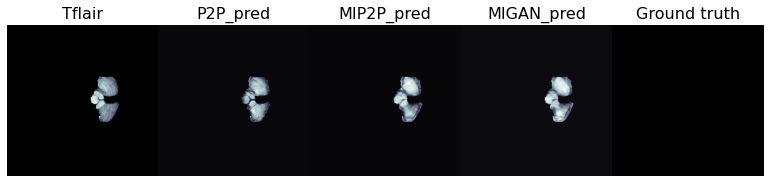

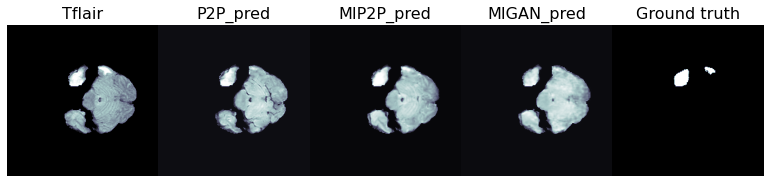

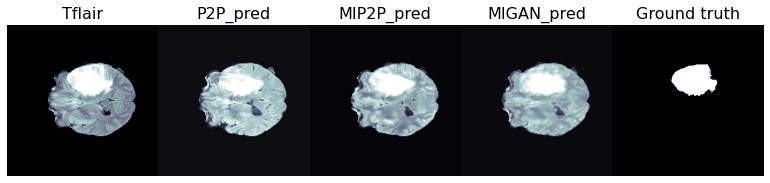

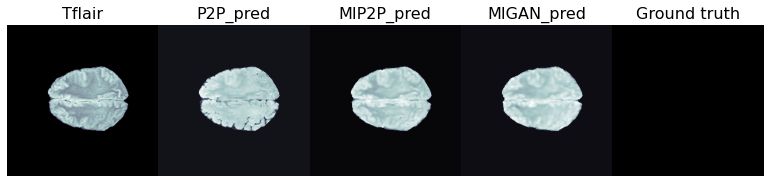

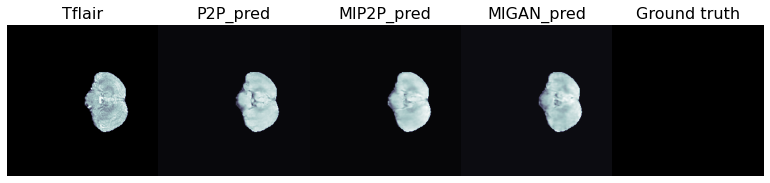

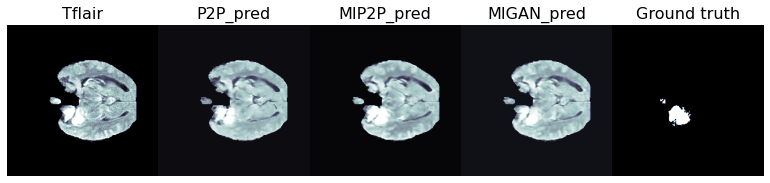

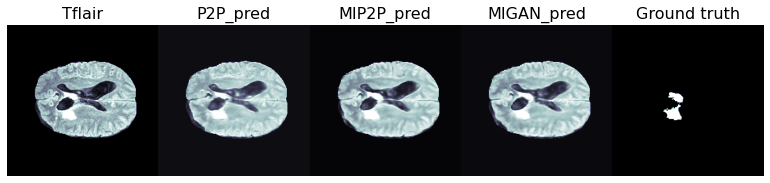

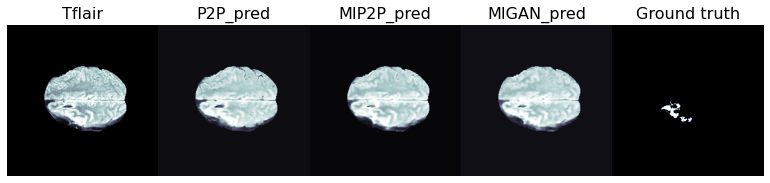

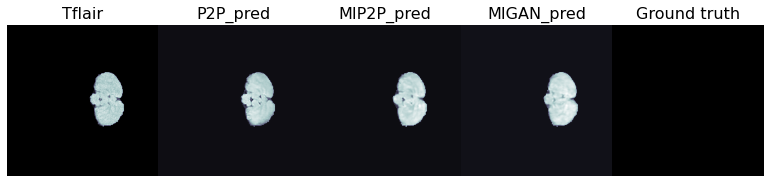

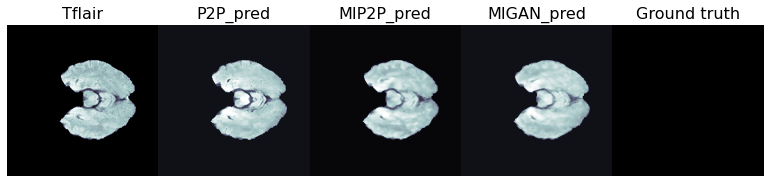

In [0]:
idx = 0
for tflair, p2p_pred, mip2p_pred, migan_pred, gt in generated_dataset.take(10):
    #print(tflair.shape)
    max_value = tf.math.reduce_max(p2p_pred)
    min_value = tf.math.reduce_min(p2p_pred)
    #print(min_value.numpy(), max_value.numpy(), (max_value-min_value).numpy())
    plot_images_new(tflair, p2p_pred, mip2p_pred, migan_pred, gt, gen_t1=True)